# **Quantized Auto-Encoder By Sajjad Roohi (NotMNIST)**

In [ ]:
!pip install QKeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyparser: filename=pyparser-1.0-py3-none-any.whl size=4913 sha256=f06a15f9342f4eeefae6809b44b4a05db2b392c33bc75c3cc8e7cce2f0f9eb75
  Stored in directory: /root/.cache/pip/wheels/25/87/78/ff95e8a747dc534fbd199fb3ea06d80935bc87e44567bbdb31
  Created wheel for parse: filename=parse-1.6.5-py3-none-any.whl size=18154 sha256=b9ed12201f06f29d1d5d03c6a184a40eff4a79a391f2b7670ea36668fb9deb5a
  Stored in directory: /root/.cache/pip/wheels/3f/10/c8/5023ea72290855ee33e7bc403e1048ae238b9c2fdb549a9f51
Successfully built pyparser parse


In [ ]:
import keras
import tensorflow as tf
from keras import layers
from keras.datasets import mnist
import numpy as np
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from matplotlib.pyplot import imread

# **Utils**

In [ ]:
def fp_quantize(x, w, f):
    """
    fixed point post quantization.
    Args:
        x: floating point (can be list) 32 bit input
        w: bit width of the target fixed point
        f: fraction bit width of the target fixed point
    Returns:
        the desired fixed point quantized of the input x
    """
    i = w - f
    max = float(2 ** (i - 1) - 2 ** (-f))
    min = float(-2 ** (i - 1))
    n = float(2 ** f)
    xx = np.floor(x * n + 0.5) / n
    clipped = np.clip(xx, a_min=min, a_max=max)
    return clipped

In [ ]:
def FPToHex(x, w = 8, f = 7):
    """
    Converts a given Fixed point number to its Hex representation.
    Args:
        x: fixed point having w bits and f bits fraction input
        w: bit width of the input
        f: fraction bit width of the input
    Returns:
        Hex representation of input
    """
    x_fix = x
    x_fix = x_fix * pow(2, f)
    x_fix = int(x_fix)
    if(x_fix < 0):
        binary = bin(x_fix+(1<<w))
    else:
        binary = bin(x_fix)
    return hex(int(binary, 2))[2:]

def WriteFixPToFile(file_name, data_fp, w = 8, f = 7, mode = "w"):
    """
    Writes given Fixed point numbers specified by w bits width and f bits fraction to the given file name.
    Args:
        file_name: file name to save the output
        data_fp: fixed point list having w bits and f bits fraction input
        w: bit width of the input
        f: fraction bit width of the input
    Returns:
        None
    """
    with open(file_name, mode) as file:
        for i in range(data_fp.shape[0]):
            file.write(str(FPToHex(data_fp[i], w=w, f=f))+'\n')

Use below function if needed (like verifying outputs or debugging).

In [ ]:
def twos_complement(bin_num):
    """
    calculates the 2's complement of the given binary number.
    Args:
        bin_num: binary number in string format
    Returns:
        the binary representation after performing 2's complement
    """

    # Perform 2's complement on the binary number
    flipped = ''
    for bit in bin_num:
        flipped += '0' if bit == '1' else '1'
    comp_num = int(flipped, 2) + 1

    return bin(comp_num)[2:].zfill(len(bin_num))

def fixed_point_to_float(bin_num, w=16, f=14):
    """
    Converts a fixed point number given in binary representation to its decimal floating point.
    Args:
        bin_num: binary number in string format
        w: bit width of the input
        f: fraction bit width of the input
    Returns:
        decimal floating point
    """
        # Check if the number is negative
    sign_bit = int(bin_num[0])
    if sign_bit:
        bin_num = twos_complement(bin_num, w, f)

    # Split the binary number into integer and fractional parts
    if f > 0:
        if f == w:
            float_num = int(bin_num, 2) / 2**f
        else:
            int_part = int(bin_num[:-f], 2)
            frac_part = int(bin_num[-f:], 2) / 2**f
            float_num = int_part + frac_part
    else:
        int_part = int(bin_num, 2)
        float_num = int_part

    # Apply the sign to the floating point number if it was negative
    if sign_bit:
        float_num = -float_num

    return float_num

def hex_to_fixed_point_decimal(hex_value, w, f):
    """
    Converts a fixed point number given in hex representation to its decimal floating point.
    Args:
        hex_value: hex number in string format
        w: bit width of the input
        f: fraction bit width of the input
    Returns:
        decimal floating point
    """
    binary_value = bin(int(hex_value, 16))[2:]

    # # Determine the sign bit
    binary_value = binary_value.zfill(w)

    # return decimal_value
    return fixed_point_to_float(binary_value, w, f)

# **Preprocess**

In [ ]:
!pip install gdown
import gdown
gdown.download("https://drive.google.com/uc?id=1gZFQRp_DQFy4QytKCnoYnlms35Kd9ysG")

Downloading...
From: https://drive.google.com/uc?id=1gZFQRp_DQFy4QytKCnoYnlms35Kd9ysG
To: /content/dataset.zip
100%|██████████| 140M/140M [00:02<00:00, 50.4MB/s]


'dataset.zip'

In [ ]:
import zipfile
zip_file_path = '/content/dataset.zip'
extract_dir = '/content/notMNIST_large'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
import numpy as np
images = np.load("/content/notMNIST_large/dataset.npy")

In [ ]:
#path = '/content/notMNIST_large'
fnames = []
for root, dir, files in images:
    for f in files:
        if f.endswith('.png'):
            fnames.append(os.path.join(root, f))

print(len(fnames))
fnames[:3]

In [ ]:
images = []
for f in fnames:
    try:
        img = imread(str(f))
        images.append(img)
    except Exception as e:
        print('Could not read:', f, ':', e, '- it\'s ok, skipping.')

images = np.array(images)

In [ ]:
len(images)

264556

In [ ]:
LATENT_SAPCE_DIM = 16
LATENT_SPACE_WIDTH = 4
LATENT_SAPCE_HEIGHT = 4
IMAGE_SIZE = 14

In [ ]:
def resize_mnist_images(images, new_size=(20, 20)):
    """
    resizes a list of images.
    Args:
        images: list of images
        new_size: the new desired size
    Returns:
        list of resized images
    """
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, new_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

In [ ]:
new_images=resize_mnist_images(images,new_size=(20,20))

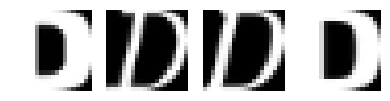

In [ ]:
import numpy as np
#images = np.load("/content/notMNIST_large/dataset.npy")
plt.figure(figsize=(4, 4))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(new_images[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
x_train, x_test = train_test_split(new_images, test_size=0.2, random_state=42)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(211644, 400)
(52912, 400)


In [ ]:
input_img = keras.Input(shape=(x_train.shape[1],))
encoded = layers.Dense(64, activation='relu')(input_img)
encoded = layers.Dense(32, activation='relu')(encoded)
#encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(LATENT_SAPCE_DIM, activation='relu')(encoded)

decoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(decoded)
#decoded = layers.Dense(256, activation='relu')(decoded)
decoded = layers.Dense(x_train.shape[1], activation='sigmoid')(decoded)
autoencoder = keras.Model(input_img, decoded)

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400)]             0         
                                                                 
 dense (Dense)               (None, 64)                25664     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 32)                544       
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 400)               26000 

In [ ]:
encoder = keras.Model(input_img, encoded)

encoded_input = keras.Input(shape=(LATENT_SAPCE_DIM,))
# Retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-4](encoded_input)
decoder_layer = autoencoder.layers[-3](encoded_input)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer)

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
827/827 [==============================] - 26s 12ms/step - loss: 0.0479 - val_loss: 0.0113
Epoch 2/50
827/827 [==============================] - 10s 12ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 3/50
827/827 [==============================] - 4s 5ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 4/50
827/827 [==============================] - 5s 6ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 5/50
827/827 [==============================] - 4s 5ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 6/50
827/827 [==============================] - 4s 5ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 7/50
827/827 [==============================] - 5s 6ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 8/50
827/827 [==============================] - 4s 5ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 9/50
827/827 [==============================] - 4s 5ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 10/50
827/827 [==============================] - 5s 6ms/step - loss: 0.0110 - val_loss: 0.

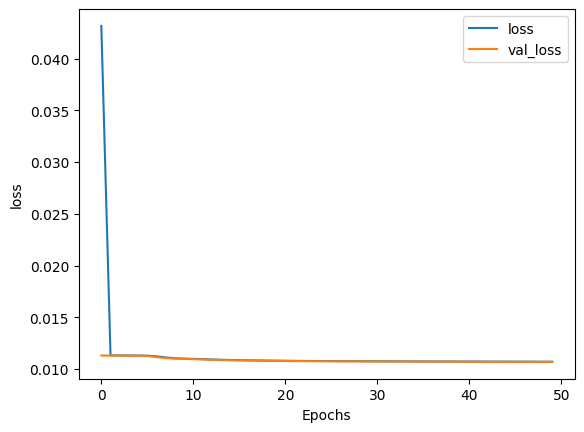

In [ ]:
autoencoder.metrics_names
historyx=history.history
loss=historyx['loss']
val_loss=historyx['val_loss']
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss','val_loss'])

In [ ]:
from keras.models import load_model
import numpy as np

def model_size_cal(model):

    all_weights = model.get_weights()
    sizes = [np.prod(w.shape) * w.itemsize for w in all_weights]
    total_size_kb = sum(sizes) / 1024.0

    return total_size_kb


model_size_kb = model_size_cal(autoencoder)
print(model_size_kb)

222.375


1654/1654 [==============================] - 3s 2ms/step


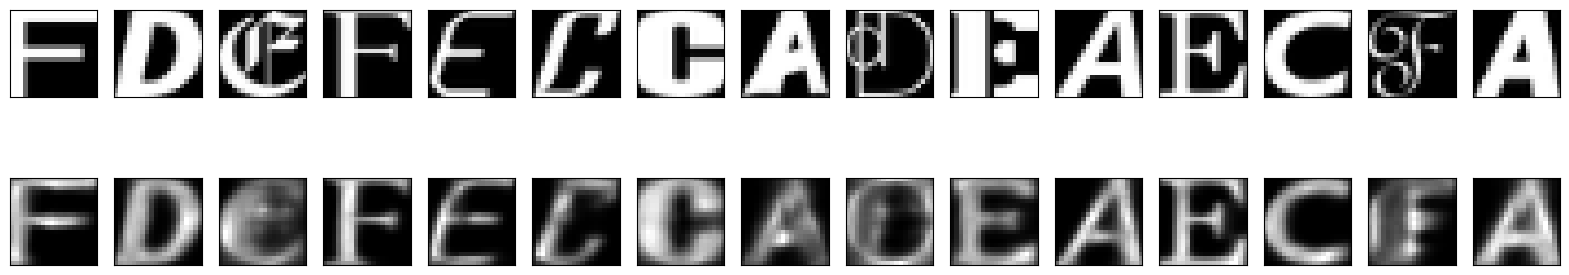

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
n = 15  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(20, 20))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(20, 20))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

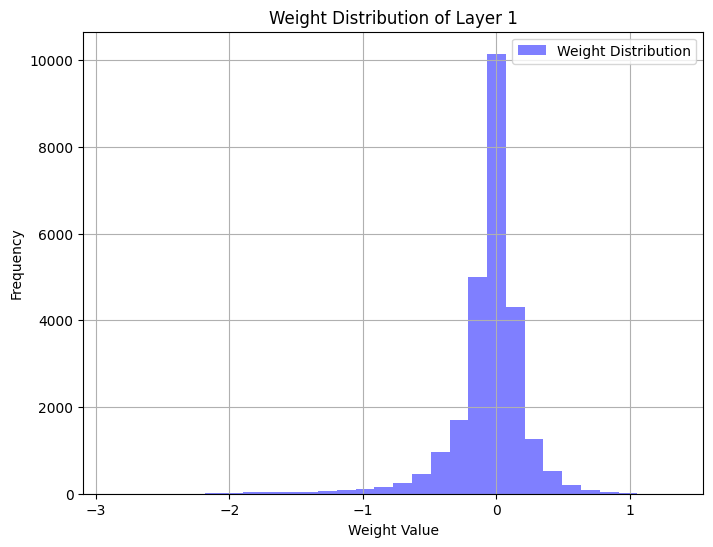

In [ ]:
layer_weights = encoder.layers[1].get_weights()

# Plot the weight distribution
if layer_weights:
    weights = layer_weights[0]

    plt.figure(figsize=(8, 6))
    plt.hist(weights.flatten(), bins=30, alpha=0.5, color='b', label='Weight Distribution')
    plt.title(f'Weight Distribution of Layer {1}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

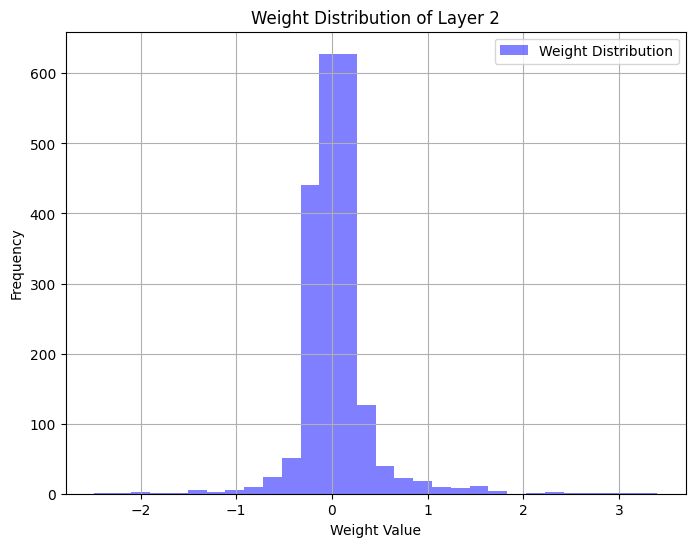

In [ ]:
layer_weights = encoder.layers[2].get_weights()

# Plot the weight distribution
if layer_weights:
    weights = layer_weights[0]

    plt.figure(figsize=(8, 6))
    plt.hist(weights.flatten(), bins=30, alpha=0.5, color='b', label='Weight Distribution')
    plt.title(f'Weight Distribution of Layer {2}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

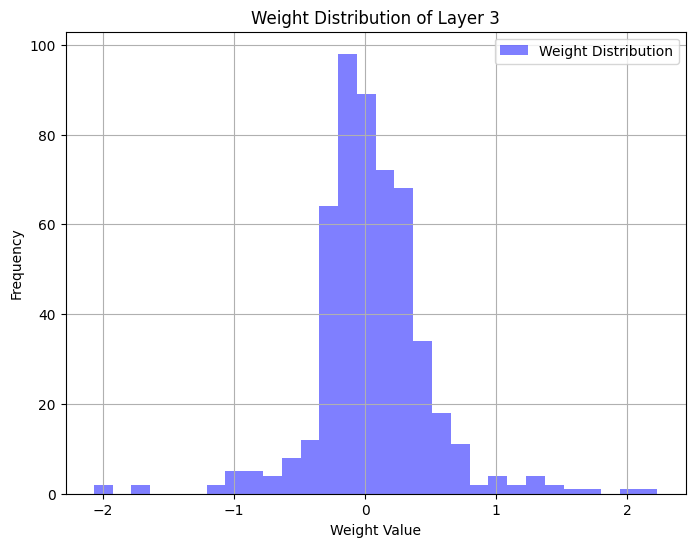

In [ ]:
layer_weights = encoder.layers[3].get_weights()

# Plot the weight distribution
if layer_weights:
    weights = layer_weights[0]

    plt.figure(figsize=(8, 6))
    plt.hist(weights.flatten(), bins=30, alpha=0.5, color='b', label='Weight Distribution')
    plt.title(f'Weight Distribution of Layer {3}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

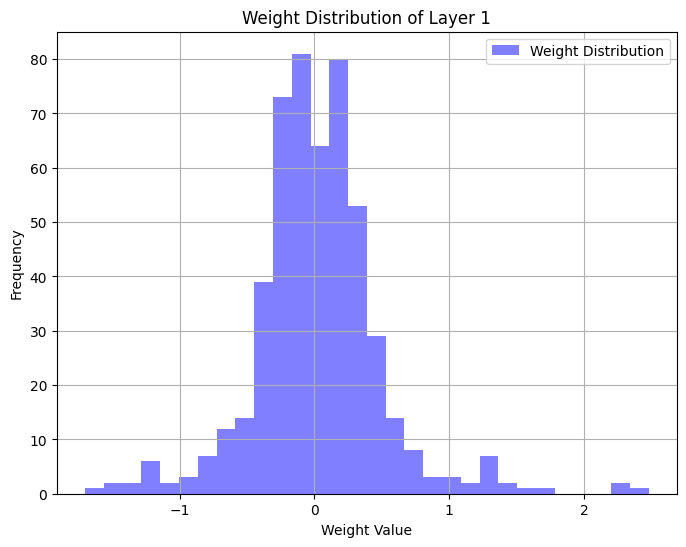

In [ ]:
layer_weights = decoder.layers[1].get_weights()

# Plot the weight distribution
if layer_weights:
    weights = layer_weights[0]

    plt.figure(figsize=(8, 6))
    plt.hist(weights.flatten(), bins=30, alpha=0.5, color='b', label='Weight Distribution')
    plt.title(f'Weight Distribution of Layer {1}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

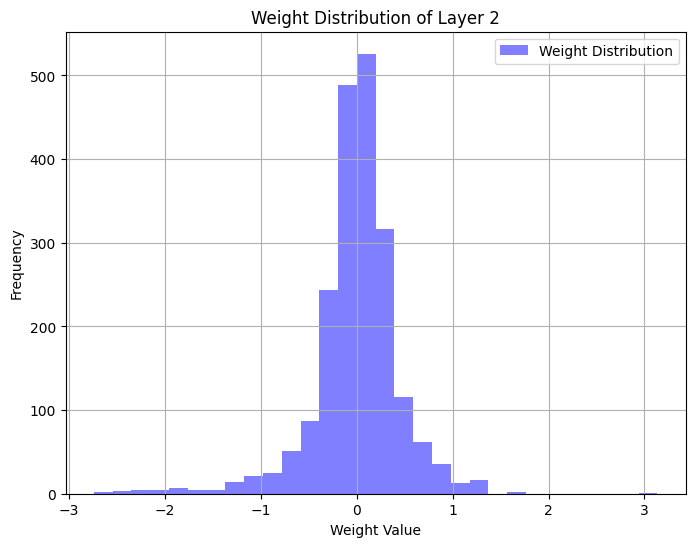

In [ ]:
layer_weights = decoder.layers[2].get_weights()

# Plot the weight distribution
if layer_weights:
    weights = layer_weights[0]

    plt.figure(figsize=(8, 6))
    plt.hist(weights.flatten(), bins=30, alpha=0.5, color='b', label='Weight Distribution')
    plt.title(f'Weight Distribution of Layer {2}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

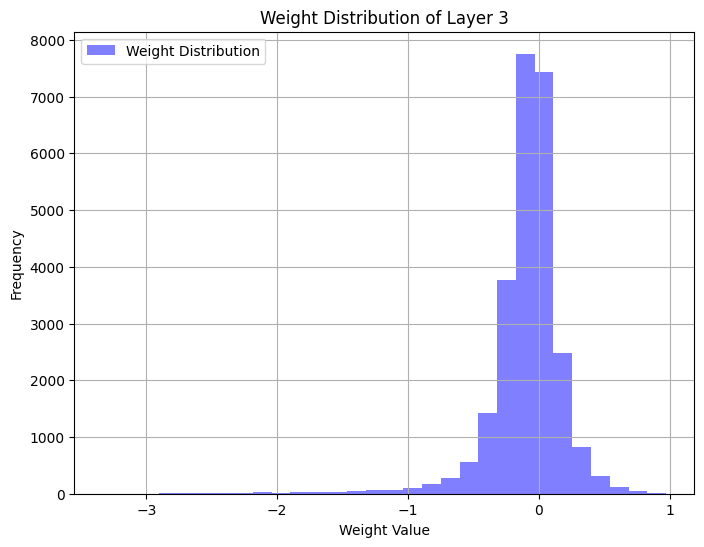

In [ ]:
layer_weights = decoder.layers[3].get_weights()

# Plot the weight distribution
if layer_weights:
    weights = layer_weights[0]

    plt.figure(figsize=(8, 6))
    plt.hist(weights.flatten(), bins=30, alpha=0.5, color='b', label='Weight Distribution')
    plt.title(f'Weight Distribution of Layer {3}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
''' Quantization of inputs'''
x_train2 = fp_quantize(x_train, 12, 9)
x_test2 = fp_quantize(x_test, 12, 9)

In [ ]:
input_img = keras.Input(shape=(x_train2.shape[1],))
encoded = QDense(64, kernel_quantizer=quantized_bits(7, 1, alpha=1), bias_quantizer=quantized_bits(7, 1, alpha=1))(input_img)
encoded = QActivation(activation=quantized_relu(7, 1))(encoded)
encoded = QDense(32, kernel_quantizer=quantized_bits(7, 1, alpha=1), bias_quantizer=quantized_bits(7, 1, alpha=1))(encoded)
encoded = QActivation(activation=quantized_relu(7, 1))(encoded)
encoded = QDense(LATENT_SAPCE_DIM, kernel_quantizer=quantized_bits(7, 2, alpha=1), bias_quantizer=quantized_bits(7, 2, alpha=1))(encoded)
encoded = QActivation(activation=quantized_relu(7, 2))(encoded)

decoded = QDense(32, kernel_quantizer=quantized_bits(7, 1, alpha=1), bias_quantizer=quantized_bits(7, 1, alpha=1))(encoded)
decoded = QActivation(activation=quantized_relu(7, 1))(decoded)
decoded = QDense(64, kernel_quantizer=quantized_bits(7, 1, alpha=1), bias_quantizer=quantized_bits(7, 1, alpha=1))(decoded)
decoded = QActivation(activation=quantized_relu(7, 1))(decoded)
decoded = QDense(x_train2.shape[1], kernel_quantizer=quantized_bits(12, 2, alpha=1), bias_quantizer=quantized_bits(12, 2, alpha=1), activation='sigmoid')(decoded)

qautoencoder = keras.Model(input_img, decoded)
qautoencoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 400)]             0         
                                                                 
 q_dense_18 (QDense)         (None, 64)                25664     
                                                                 
 q_activation_15 (QActivati  (None, 64)                0         
 on)                                                             
                                                                 
 q_dense_19 (QDense)         (None, 32)                2080      
                                                                 
 q_activation_16 (QActivati  (None, 32)                0         
 on)                                                             
                                                                 
 q_dense_20 (QDense)         (None, 16)                528

In [ ]:
qautoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = qautoencoder.fit(x_train2, x_train2,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test2, x_test2))

Epoch 1/50
827/827 [==============================] - 11s 10ms/step - loss: 0.0570 - val_loss: 0.0114
Epoch 2/50
827/827 [==============================] - 8s 9ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 3/50
827/827 [==============================] - 6s 7ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 4/50
827/827 [==============================] - 7s 8ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 5/50
827/827 [==============================] - 6s 7ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 6/50
827/827 [==============================] - 7s 8ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 7/50
827/827 [==============================] - 6s 8ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 8/50
827/827 [==============================] - 7s 8ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 9/50
827/827 [==============================] - 6s 7ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 10/50
827/827 [==============================] - 7s 8ms/step - loss: 0.0111 - val_loss: 0.01

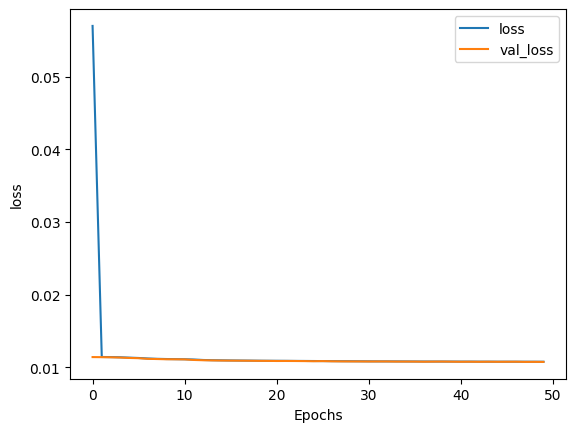

In [ ]:

historyx=history.history
loss=historyx['loss']
val_loss=historyx['val_loss']
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss','val_loss'])

In [ ]:
qencoder = keras.Model(input_img, encoded)
encoded_input = keras.Input(shape=(LATENT_SAPCE_DIM,))
# Retrieve the last layer of the autoencoder model
decoder_layer = qautoencoder.layers[-5](encoded_input)
decoder_layer = qautoencoder.layers[-4](decoder_layer)
decoder_layer = qautoencoder.layers[-3](decoder_layer)
decoder_layer = qautoencoder.layers[-2](decoder_layer)
decoder_layer = qautoencoder.layers[-1](decoder_layer)
# Create the decoder model
qdecoder = keras.Model(encoded_input, decoder_layer)
#encoded_imgs = qencoder.predict(x_test2)
#decoded_imgs = qdecoder.predict(encoded_imgs)


1654/1654 [==============================] - 10s 5ms/step


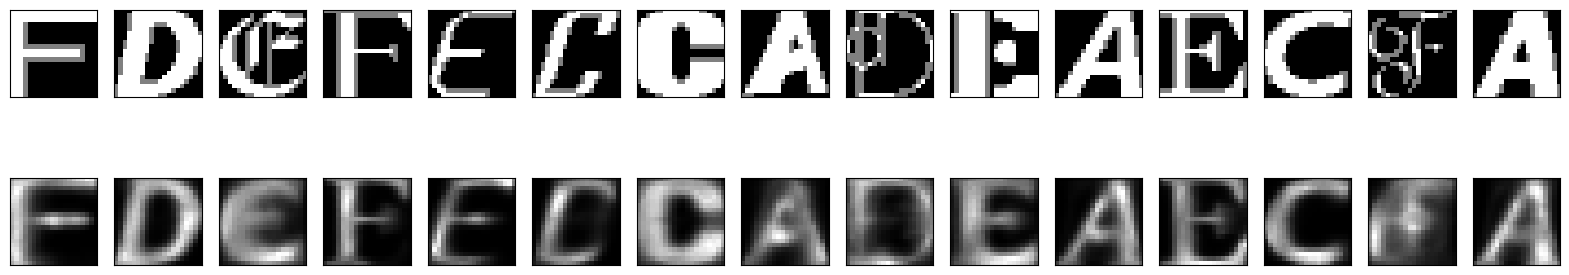

In [ ]:
encoded_imgs = qencoder.predict(x_test2)
decoded_imgs = qdecoder.predict(encoded_imgs)
n = 15  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test2[i].reshape(20, 20))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(20, 20))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
if not os.path.exists('weights'):
    os.mkdir('weights')
os.mkdir('weights__qencoder')
os.mkdir('weights__qdecoder')
os.mkdir('weights__qautoencoder')
for i, layer in enumerate(qautoencoder.layers):
    weights = layer.get_weights()
    if weights and len(weights) > 0:
        w_per_neuron = weights[0].shape[0]
        w = np.einsum("ij->ji", weights[0]).reshape(-1,)
        b = weights[1].reshape(-1,)
        separate_weights = [np.concatenate((w[c:c+w_per_neuron], b[int(c/w_per_neuron):int(c/w_per_neuron)+1]), axis=0) for c in range(0, len(w), w_per_neuron)]

        width, f = (12, 9) if layer.name == 'last' else (7, 5)
        for n, s in enumerate(separate_weights):
            WriteFixPToFile(f"weights__qencoder/layer_{i + 1}_{n + 1}_w.txt", s, width, f)


In [ ]:
for i, layer in enumerate(qautoencoder.layers):
    weights = layer.get_weights()
    if weights and len(weights) > 0:
        w_per_neuron = weights[0].shape[0]
        w = np.einsum("ij->ji", weights[0]).reshape(-1,)
        b = weights[1].reshape(-1,)
        separate_weights = [np.concatenate((w[c:c+w_per_neuron], b[int(c/w_per_neuron):int(c/w_per_neuron)+1]), axis=0) for c in range(0, len(w), w_per_neuron)]

        width, f = (12, 9) if layer.name == 'last' else (7, 5)
        for n, s in enumerate(separate_weights):
            WriteFixPToFile(f"weights__qdecoder/layer_{i + 1}_{n + 1}_w.txt", s, width, f)


In [ ]:
import zipfile
import os

def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

folder_path = '/content/weights__qdecoder'
zip_path = '/content/weights__qdecoder_zipped.zip'

zip_folder(folder_path, zip_path)

In [ ]:
WriteFixPToFile(f"Input1.txt", x_train2[0], 17, 14)
WriteFixPToFile(f"Input2.txt", x_train2[1], 17, 14)